In [1]:
!pip uninstall -y numpy
!pip install numpy==1.26.4

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
  Using cached numpy-1.26.4-cp312-cp312-macosx_11_0_arm64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp312-cp312-macosx_11_0_arm64.whl (13.7 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
streamlit 1.32.0 requires packaging<24,>=16.8, but you have packaging 25.0 which is incompatible.
streamlit 1.32.0 requires rich<14,>=10.14.0, but you have rich 14.0.0 which is incompatible.


In [2]:
import numpy as np
print(np.__version__)  # 确认是 1.26.4


1.26.4


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.metrics import (classification_report, confusion_matrix, 
                            roc_auc_score, roc_curve, precision_recall_curve, 
                            auc)
from sklearn.inspection import permutation_importance

In [4]:
import os
os.getcwd()


'/Users/zhengshuyu/Downloads/ML/finaproject'

In [5]:
# Load data
df = pd.read_csv('Telco-Customer-Churn-Data.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'Telco-Customer-Churn-Data.csv'

In [20]:
# Data preprocessing
# Convert TotalCharges to numeric, handle blank values
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

In [22]:
# Encode target
df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})

In [24]:
# Define features and target
X = df.drop(['customerID', 'Churn'], axis=1)
y = df['Churn']

In [26]:
# Identify feature types
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges', 'SeniorCitizen']

In [28]:
# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ])

In [30]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [32]:
# Apply preprocessing
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [34]:
# Get feature names
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
feature_names = numerical_features + cat_feature_names.tolist()

In [36]:
# Train SVM model
svm = SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=42)
svm.fit(X_train_preprocessed, y_train)

SVC(class_weight='balanced', probability=True, random_state=42)

In [38]:
# Predict
y_pred = svm.predict(X_test_preprocessed)
y_proba = svm.predict_proba(X_test_preprocessed)[:, 1]

In [40]:
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.73      0.81      1552
           1       0.51      0.79      0.62       561

    accuracy                           0.75      2113
   macro avg       0.71      0.76      0.72      2113
weighted avg       0.80      0.75      0.76      2113

ROC-AUC Score: 0.8237470597423598


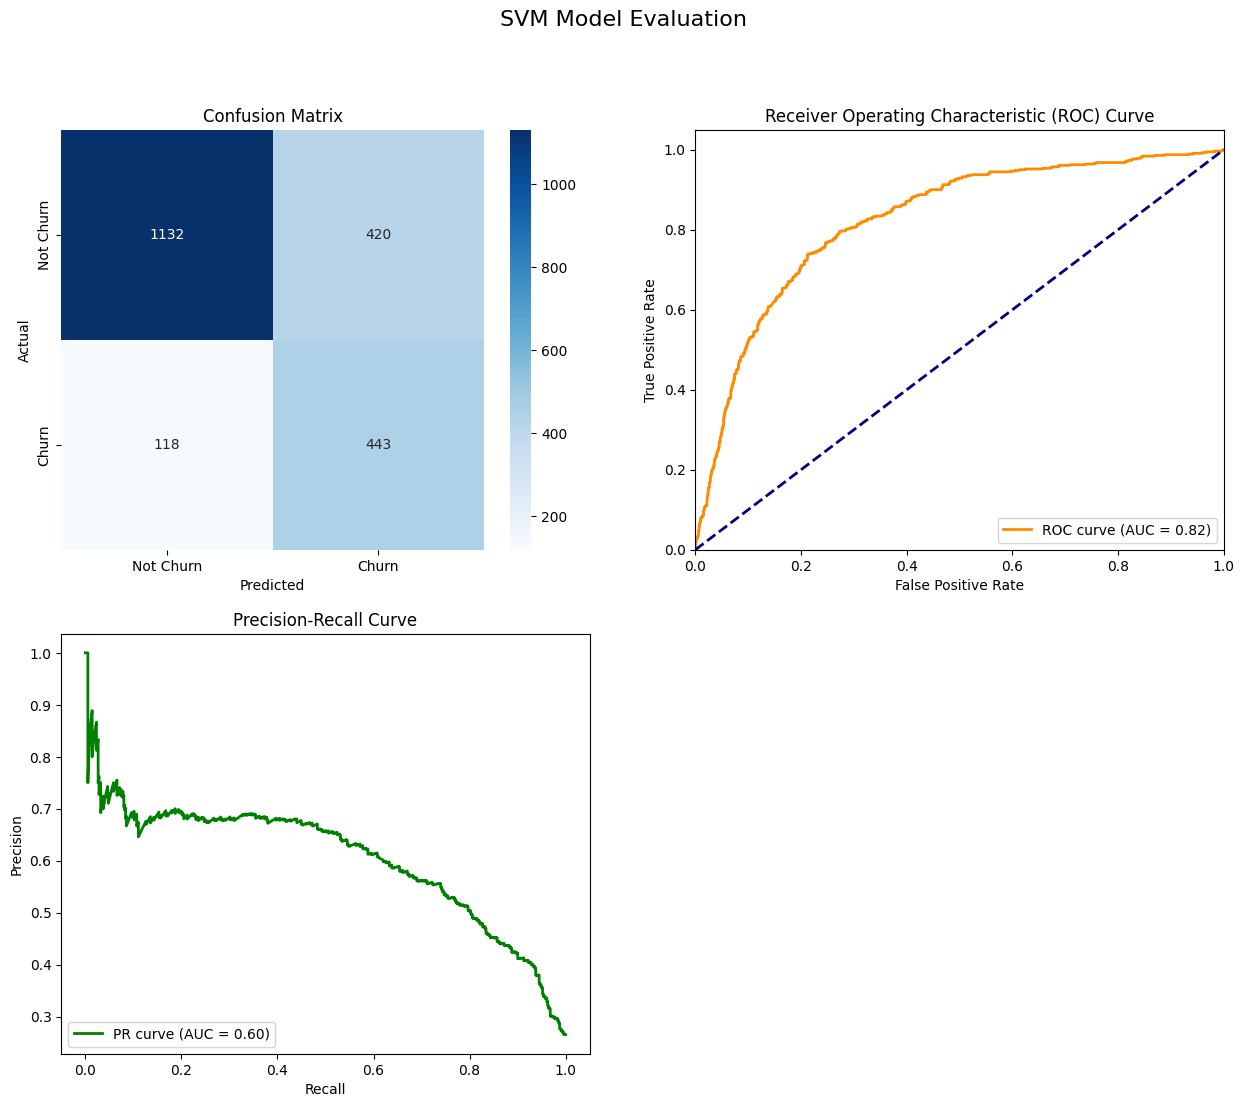

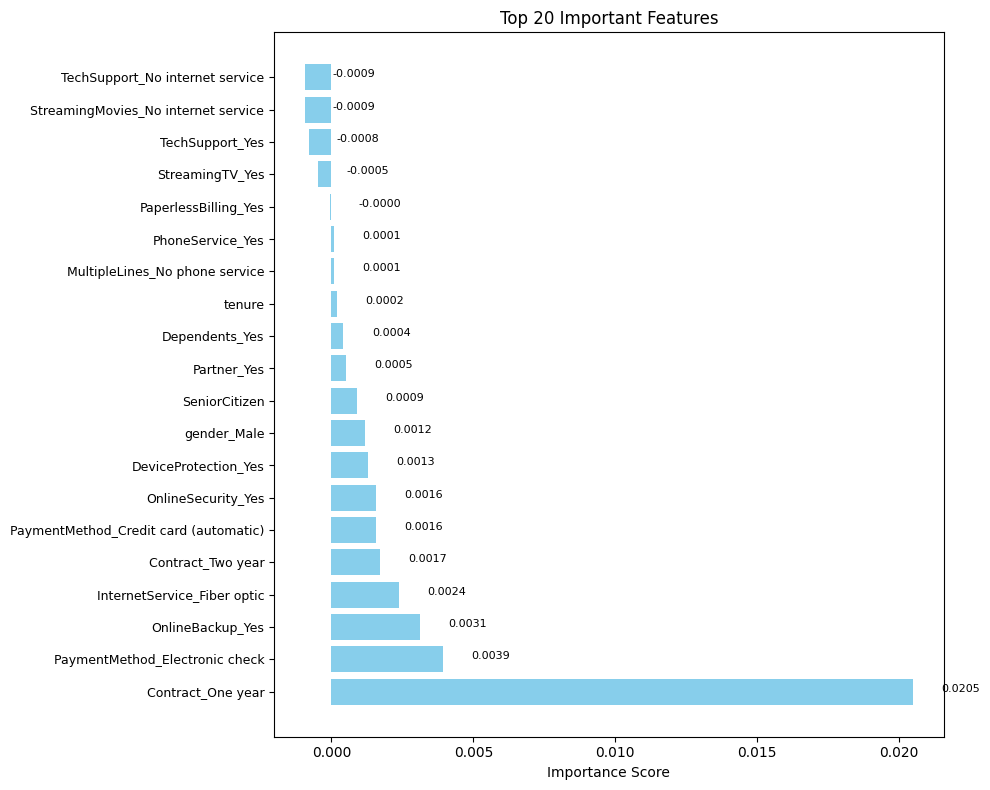

In [42]:
plt.figure(figsize=(15, 12))
plt.suptitle('SVM Model Evaluation', fontsize=16)

# 1. Confusion Matrix
plt.subplot(2, 2, 1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Churn', 'Churn'], 
            yticklabels=['Not Churn', 'Churn'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

# 2. ROC Curve
plt.subplot(2, 2, 2)
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# 3. Precision-Recall Curve
plt.subplot(2, 2, 3)
precision, recall, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)
plt.plot(recall, precision, color='green', lw=2, label=f'PR curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
# 4. Feature Importance (Permutation Importance)
result = permutation_importance(
    svm, X_test_preprocessed, y_test, n_repeats=10, random_state=42
)
# Get top 20 most important features
sorted_idx = result.importances_mean.argsort()[-20:]
top_features = np.array(feature_names)[sorted_idx]
top_importances = result.importances_mean[sorted_idx]
# Create plot with better spacing
fig, ax = plt.subplots(figsize=(10, 8))
y_pos = np.arange(len(top_features))
ax.barh(y_pos, top_importances, align='center', color='skyblue')
ax.set_yticks(y_pos)
ax.set_yticklabels(top_features, fontsize=9)  # Slightly smaller font
ax.invert_yaxis()  # Most important at top
ax.set_xlabel('Importance Score')
ax.set_title('Top 20 Important Features')
# Add importance values at end of bars
for i, v in enumerate(top_importances):
    ax.text(v + 0.001, i, f"{v:.4f}", color='black', fontsize=8)
plt.tight_layout()

C:\Users\x\AppData\Local\Temp\ipykernel_16696\471898099.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  funnel = df_seg.groupby('risk')['actual'].agg(['count','sum'])
C:\Users\x\AppData\Local\Temp\ipykernel_16696\471898099.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


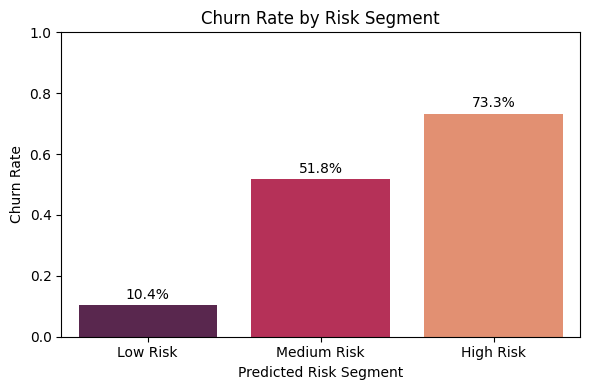

In [49]:
##########5.1
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# —— 前提：已有 y_test（Series），y_proba（pred_proba[:,1]），X_test_preprocessed（ndarray），feature_names（列表） —— 

# 1. 把 X_test_preprocessed 转成 DataFrame
X_test_df = pd.DataFrame(
    X_test_preprocessed,
    columns=feature_names,
    index=y_test.index
)

# 2. 生成风险分档
bins   = [0.0, 0.33, 0.66, 1.0]
labels = ['Low Risk','Medium Risk','High Risk']
risk = pd.cut(y_proba, bins=bins, labels=labels)
df_seg = pd.DataFrame({'risk': risk, 'actual': y_test})

# 3. 画流失率分档条形图
funnel = df_seg.groupby('risk')['actual'].agg(['count','sum'])
funnel['churn_rate'] = funnel['sum'] / funnel['count']

plt.figure(figsize=(6,4))
sns.barplot(
    x=funnel.index,
    y='churn_rate',
    data=funnel.reset_index(),
    palette='rocket'
)
plt.title('Churn Rate by Risk Segment')
plt.xlabel('Predicted Risk Segment')
plt.ylabel('Churn Rate')
plt.ylim(0,1)
for i, v in enumerate(funnel['churn_rate']):
    plt.text(i, v+0.02, f"{v:.1%}", ha='center')
plt.tight_layout()
plt.show()


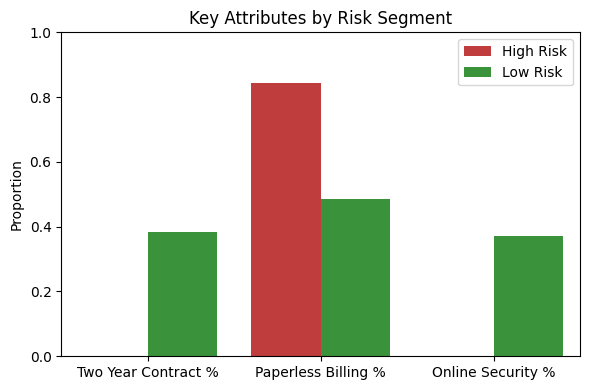

In [51]:
#########5.1
# 1. 只取 High Risk 和 Low Risk 两个组
profile = []
for grp in ['High Risk','Low Risk']:
    idx = df_seg[df_seg['risk']==grp].index
    d   = X_test_df.loc[idx, [   # 注意列名要跟你 .env-live 里的一致
        'Contract_Two year',
        'PaperlessBilling_Yes',
        'OnlineSecurity_Yes'
    ]]
    profile.append({
        'segment':              grp,
        'Two Year Contract %':  d['Contract_Two year'].mean(),
        'Paperless Billing %':  d['PaperlessBilling_Yes'].mean(),
        'Online Security %':    d['OnlineSecurity_Yes'].mean()
    })

prof_df = (
    pd.DataFrame(profile)
      .melt('segment', var_name='feature', value_name='pct')
)

plt.figure(figsize=(6,4))
sns.barplot(
    x='feature', y='pct',
    hue='segment',
    data=prof_df,
    palette=['#d62728','#2ca02c']
)
plt.title('Key Attributes by Risk Segment')
plt.ylabel('Proportion')
plt.xlabel('')
plt.ylim(0,1)
plt.legend(title=None, loc='upper right')
plt.tight_layout()
plt.show()


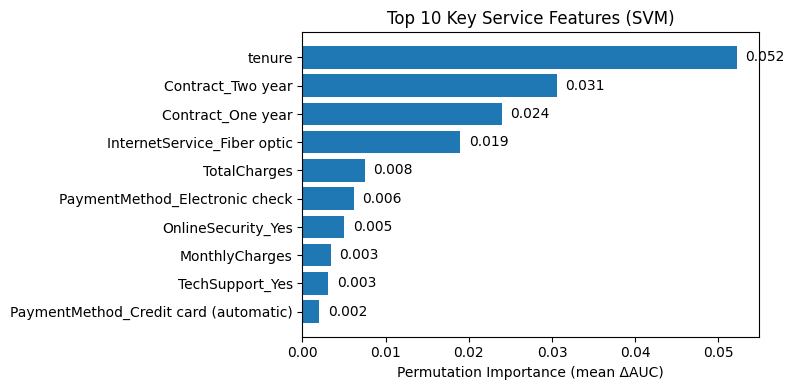

In [53]:
############5.2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

# —— 前提：已经有训练好的 svm 模型、X_test_preprocessed, y_test, feature_names, 以及 pipeline 里最后一步输出概率的方式 —— 

# 1. 计算置换重要性
result = permutation_importance(
    svm,                # 你的 SVM 模型实例
    X_test_preprocessed,
    y_test,
    n_repeats=10,
    random_state=42,
    scoring='roc_auc'
)

# 2. 按 mean importance 排序，取前 10
importances = result.importances_mean
idx_sorted = np.argsort(importances)[::-1][:10]
top_feats   = np.array(feature_names)[idx_sorted]
top_scores  = importances[idx_sorted]

# 3. 画水平条形图
plt.figure(figsize=(8,4))
y_pos = np.arange(len(top_feats))
plt.barh(y_pos, top_scores, align='center')
plt.yticks(y_pos, top_feats)
plt.gca().invert_yaxis()
plt.xlabel('Permutation Importance (mean ΔAUC)')
plt.title('Top 10 Key Service Features (SVM)')
for i, v in enumerate(top_scores):
    plt.text(v + 0.001, i, f"{v:.3f}", va='center')
plt.tight_layout()
plt.show()


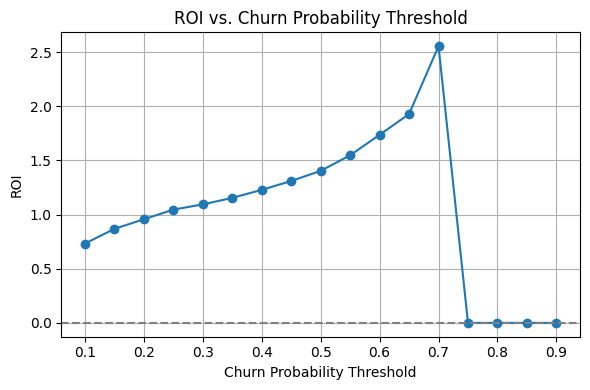

In [54]:
###########5.3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# —— 前提：已有 y_proba（模型预测的 churn 概率）, y_test —— 

cost_per = 50    # 挽留成本
rev_per  = 200   # 成功挽留收益

ths = np.linspace(0.1, 0.9, 17)
records = []
for t in ths:
    # 挑出需要挽留的人群
    idx_target = np.where(y_proba >= t)[0]
    n_target   = len(idx_target)
    # 实际这些人中有多少是 churn
    n_churn    = y_test.iloc[idx_target].sum()
    # 计算总成本、总收益、ROI
    total_cost    = n_target * cost_per
    total_benefit = n_churn * rev_per
    roi           = (total_benefit - total_cost) / total_cost if total_cost>0 else 0
    records.append({
        'threshold': t,
        'n_target': n_target,
        'n_actual_churn': n_churn,
        'total_cost': total_cost,
        'total_benefit': total_benefit,
        'ROI': roi
    })

df_roi = pd.DataFrame(records)

# 画 ROI 曲线
plt.figure(figsize=(6,4))
plt.plot(df_roi['threshold'], df_roi['ROI'], marker='o')
plt.axhline(0, color='gray', linestyle='--')
plt.title('ROI vs. Churn Probability Threshold')
plt.xlabel('Churn Probability Threshold')
plt.ylabel('ROI')
plt.grid(True)
plt.tight_layout()
plt.show()
